In [160]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, PowerTransformer
from scipy import stats

In [ ]:
categorical = ['productgroup', 'gender', 'category', 'style', 'sizes']
invariant = ['promo1', 'promo2']
target = ['sales']
numerical = ['regular_price', 'current_price', 'ratio', 'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col']

In [40]:
Austria = pd.read_parquet("../data/02_intermediate/Austria.pq")
France = pd.read_parquet("../data/02_intermediate/France.pq")
Germany = pd.read_parquet("../data/02_intermediate/Germany.pq")
Countries = {"Austria":Austria,"France":France,"Germany": Germany}

# Check for normality in Sales

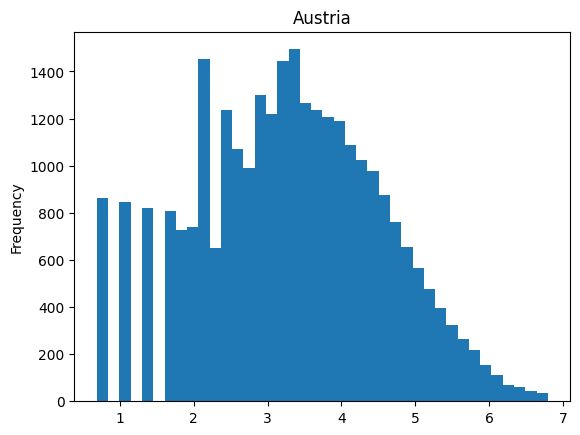

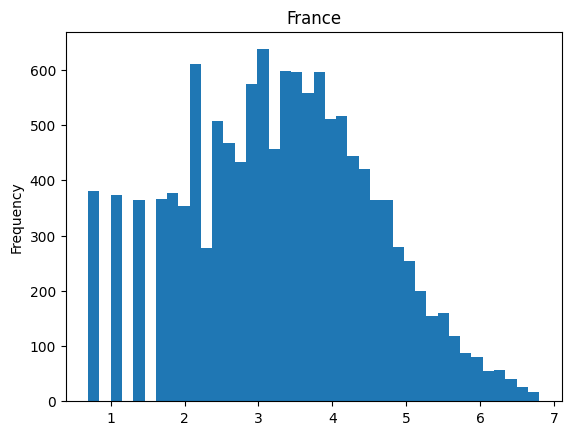

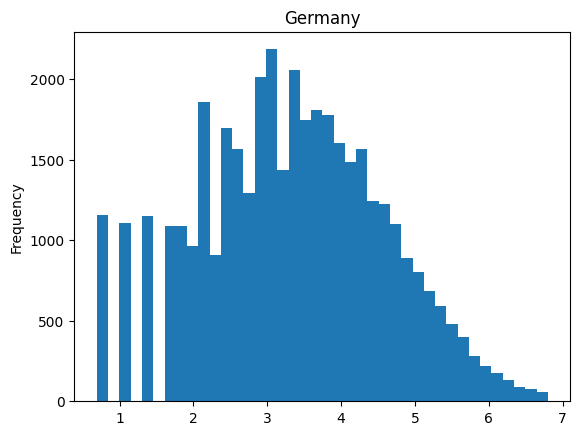

In [42]:
for i in Countries:
    Countries[i].sales.apply(np.log1p).plot.hist(bins=40,title=i)
    plt.show()

In [47]:

def power_transform(df,title): 
    pt = PowerTransformer()

    sales_data = pt.fit_transform(df.sales.values.reshape(-1,1))
    sales_data=np.ravel(sales_data)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    axes[1,0].hist(sales_data, bins=40, edgecolor='black')
    axes[1,0].set_xlabel("Value")
    axes[1,0].set_ylabel("Frequency")

    axes[1,1].hist(df.sales, bins=40, edgecolor="black")
    axes[1,1].set_xlabel("Value")
    axes[1,1].set_ylabel("Frequency")



    stats.probplot(sales_data, dist='norm', plot=axes[0,0])
    axes[0,0].set_title("Q-Q plot")

    sorted_data = np.sort(sales_data)

    # Calculate the cumulative probabilities for the observed data
    observed_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Calculate the cumulative probabilities for the normal distribution
    normal_cdf = stats.norm.cdf(sorted_data, loc=np.mean(sales_data), scale=np.std(sales_data))
    # Plot the P-P plot
    axes[0,1].plot(normal_cdf, observed_cdf, 'o')
    axes[0,1].plot([0, 1], [0, 1], 'k--') # Diagonal line
    axes[0,1].set_xlabel("Theoretical CDF")
    axes[0,1].set_ylabel("Observed CDF")
    axes[0,1].set_title("P-P Plot")
    plt.tight_layout()
    plt.show()
    

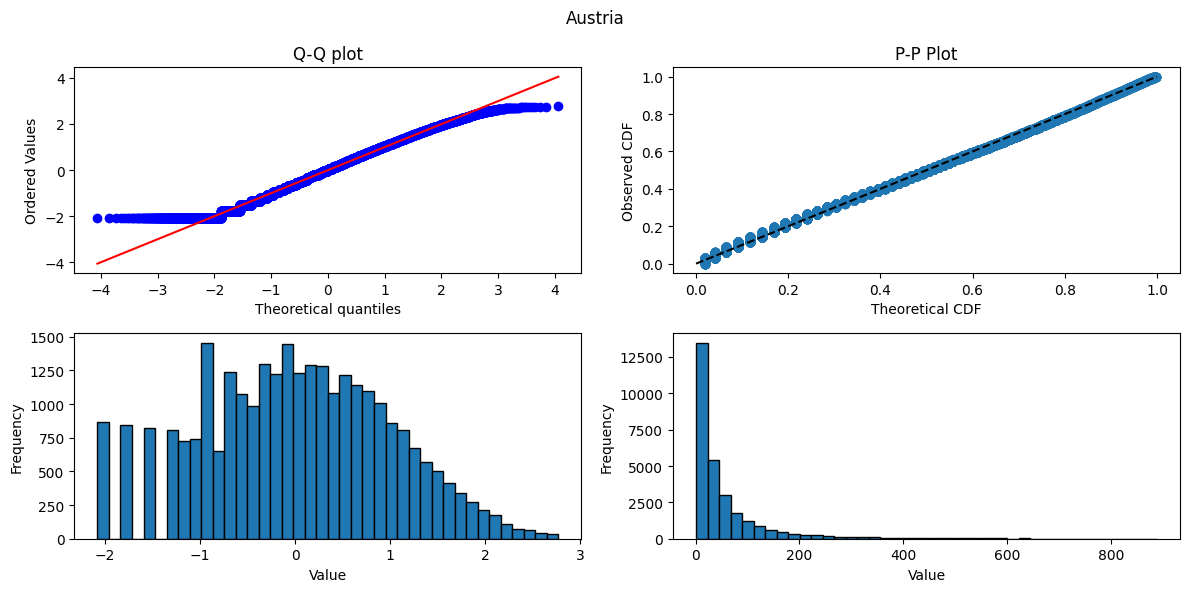

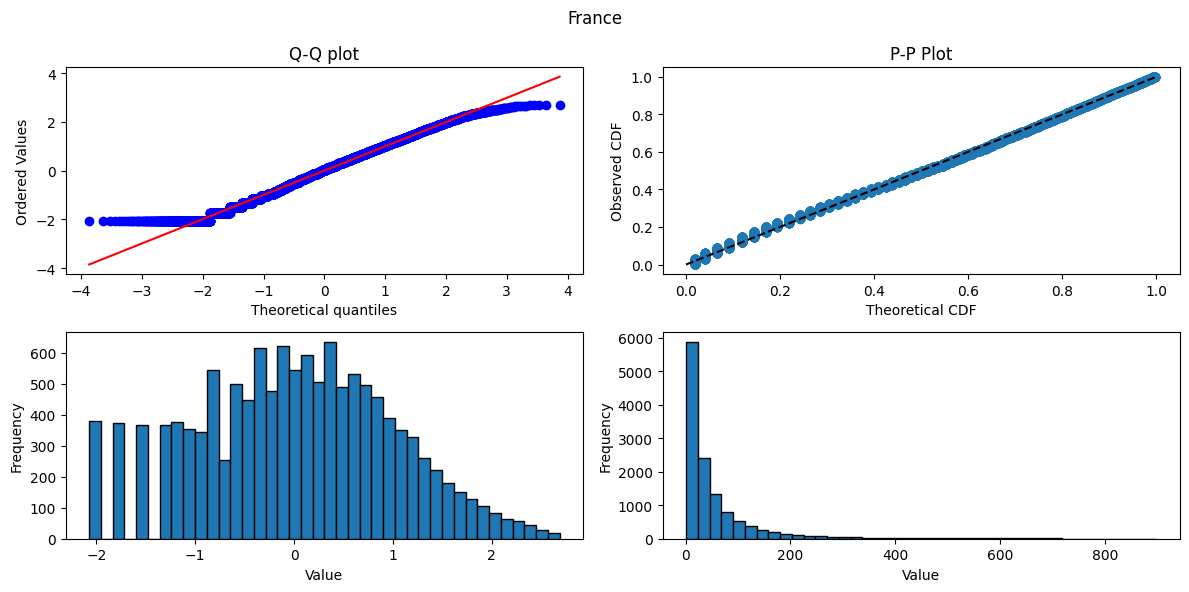

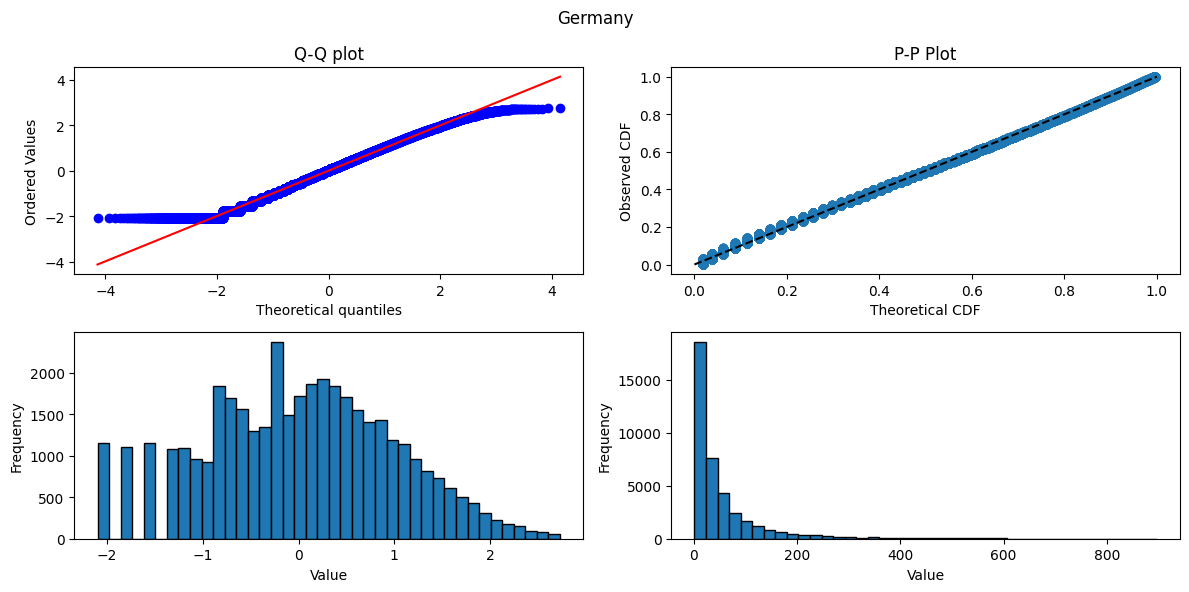

In [48]:
for i in Countries:
    power_transform(Countries[i],i)

Things are not normal but we can keep going on using a regression model for forecast

In [226]:
categorical = ['productgroup', 'gender', 'style']
bucket=['sizes']
invariant = ['promo1', 'promo2',]
target = ['sales']
numerical = ['regular_price','current_price','main_rgb','sec_rgb','ratio']

In [227]:
Austria = pd.read_parquet("../data/02_intermediate/Austria.pq")
France = pd.read_parquet("../data/02_intermediate/France.pq")
Germany = pd.read_parquet("../data/02_intermediate/Germany.pq")
Countries = {"Austria":Austria,"France":France,"Germany": Germany}
for i in Countries:
    Countries[i]["main_rgb"] = 0.3*Countries[i]["rgb_r_main_col"]+ 0.6*Countries[i]["rgb_g_main_col"]+0.11*Countries[i]["rgb_b_main_col"] 
    Countries[i]["sec_rgb"] = 0.3*Countries[i]["rgb_r_sec_col"]+ 0.6*Countries[i]["rgb_g_sec_col"]+0.11*Countries[i]["rgb_b_sec_col"] 
    Countries[i]["retailweek"] = pd.to_datetime(Countries[i]["retailweek"], format="%Y-%m-%d")
    Countries[i]=Countries[i].sort_values(by="retailweek").set_index("retailweek")


In [228]:
for i in Countries:
    print((Countries[i].index < "2017-01-01").sum()/len(Countries[i]))

0.8536585365853658
0.8536585365853658
0.8536585365853658


In [229]:
def bucketize(sizes):
    all_sizes = set(['xxs', 'xs', 's', 'm', 'l', 'xl', 'xxl'])
    sizes_set = set(sizes.split(','))

    if sizes_set == all_sizes:
        return "has it all"
    elif sizes_set & set(['xxs', 'xs', 's']):
        return "has small"
    elif sizes_set & set(['l', 'xl', 'xxl']):
        return "has big"
    else:
        return "other"
def Train_test_split(df:pd.DataFrame):
    #df["size_type"]=df["sizes"].apply(bucketize)
    X,y = df[invariant+categorical+numerical+bucket],df[target]
    # split 80 -20
    new_X, X_test, new_y, y_test = X.loc[X.index < "2017-01-01"], X.loc[X.index > "2017-01-01"],y.loc[y.index < "2017-01-01"], y.loc[y.index > "2017-01-01"] 
    # split 80-20
    X_train, X_val, y_train, y_val = new_X.loc[new_X.index<"2016-08-01"], new_X.loc[new_X.index>"2016-08-01"], new_y.loc[new_y.index<"2016-08-01"], new_y.loc[new_y.index >"2016-08-01"]
    return X_train,X_val,X_test, y_train, y_val, y_test

In [230]:
X_train, X_val, X_test, y_train, y_val, y_test = Train_test_split(Countries[i])

In [231]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomBucketizer(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.categories = categories

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply the bucketize function to the input column
        bucketized = X.applymap(bucketize).iloc[:,0]

        # Create a OneHotEncoder with the specified categories
        encoder = OneHotEncoder(categories=[self.categories])

        # Fit and transform the bucketized column
        one_hot_encoded = encoder.fit_transform(bucketized.values.reshape(-1, 1))

        return one_hot_encoded.toarray()

In [232]:
# Define the possible categories for the bucketized variable
bucket_categories = ['has it all', 'has small', 'has big', 'has medium', 'other']

# Define the custom transformer for the bucketized variable
bucket_transformer = CustomBucketizer(categories=bucket_categories)

features_preprocessor = ColumnTransformer(

    transformers= [
        ('numerical', StandardScaler(),numerical),
        ('categorical', OneHotEncoder(handle_unknown="infrequent_if_exist"),categorical),
        ('bucketized', bucket_transformer,bucket),
        ('invariants','passthrough', invariant)
    ])


In [233]:
from sklearn.ensemble import RandomForestRegressor
#regr =TransformedTargetRegressor(regressor=RandomForestRegressor(oob_score=True,criterion='squared_error'),transformer=PowerTransformer())
regr=RandomForestRegressor(oob_score=True,criterion='poisson')
#pipe_data = Pipeline(steps=[('preprocessor', features_preprocessor),])
#pipe_data.fit(X_train)
pipe = Pipeline(steps=[('preprocessor', features_preprocessor),('scaled_regression',regr)])
#regr =RandomForestRegressor(oob_score=True,criterion="poisson")
#pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
pipe.fit(X_train,y_train.values)


/Users/jamontanac/miniconda3/envs/dsCase/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['regular_price',
                                                   'current_price', 'main_rgb',
                                                   'sec_rgb', 'ratio']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['productgroup', 'gender',
                                                   'style']),
                                                 ('bucketized',
                                                  CustomBucketizer(categories=['has '
                                                                               'it '
                                                                               'all',
                                                                               'has '
                                                                               'small',
                                                                               'has '
                                                                               'big',
                                                                               'has '
                                                                               'medium',
                                                                               'other']),
                                                  ['sizes']),
                                                 ('invariants', 'passthrough',
                                                  ['promo1', 'promo2'])])),
                ('scaled_regression',
                 RandomForestRegressor(criterion='poisson', oob_score=True))])

In [239]:
preprocessor = pipe.named_steps['preprocessor']
numerical_features = numerical
categorical_features = preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical)
bucketized_features = bucket_categories
final_feature_names = list(numerical_features) + list(categorical_features) + list(bucketized_features) + list(invariant)

print(final_feature_names)


['regular_price', 'current_price', 'main_rgb', 'sec_rgb', 'ratio', 'productgroup_HARDWARE ACCESSORIES', 'productgroup_PANTS', 'productgroup_SHOES', 'productgroup_SHORTS', 'productgroup_SWEATSHIRTS', 'productgroup_T-SHIRTS', 'gender_kids', 'gender_men', 'gender_unisex', 'gender_women', 'style_regular', 'style_slim', 'style_wide', 'has it all', 'has small', 'has big', 'has medium', 'other', 'promo1', 'promo2']


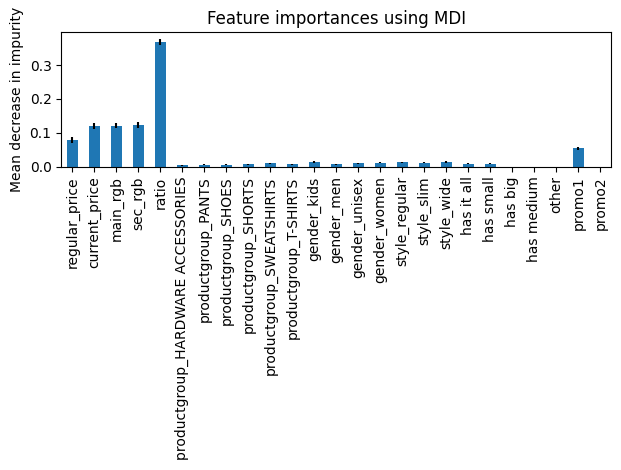

In [240]:
importances = pipe["scaled_regression"].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe["scaled_regression"].estimators_], axis=0)
feature_names = [i for i in final_feature_names]
forest_importances = pd.Series(importances,index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [259]:
pipe["preprocessor"]

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['regular_price', 'current_price', 'main_rgb',
                                  'sec_rgb', 'ratio']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['productgroup', 'gender', 'style']),
                                ('bucketized',
                                 CustomBucketizer(categories=['has it all',
                                                              'has small',
                                                              'has big',
                                                              'has medium',
                                                              'other']),
                                 ['sizes']),
                                ('invariants', 'passthrough',
                                 ['promo1', 'promo2'])])

In [261]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    pipe, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2
)


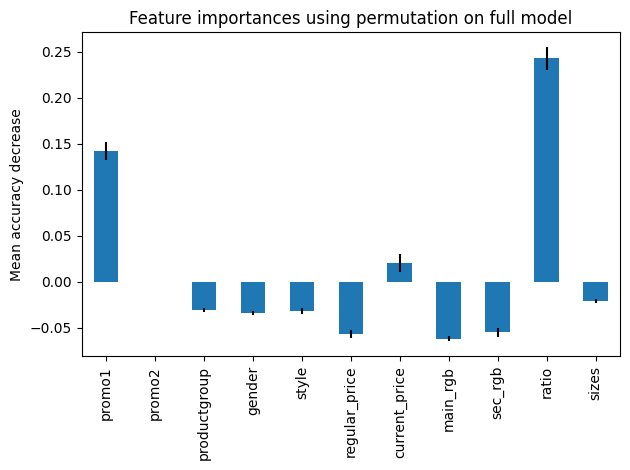

In [263]:
result = permutation_importance(
    pipe, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean,index=X_train.columns.values)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [275]:
import plotly.express as px

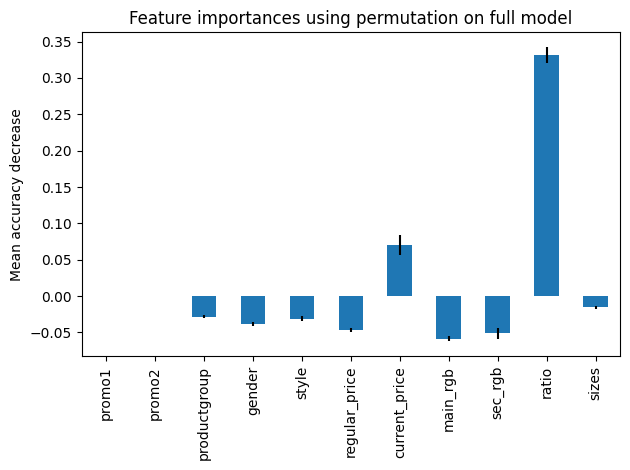

In [264]:
result = permutation_importance(
    pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean,index=X_train.columns.values)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [279]:
pd.DataFrame(forest_importances,columns=["values"])

,values
promo1,0.218605
promo2,0.000000
productgroup,0.025136
gender,0.037245
style,0.028324
regular_price,0.100490
current_price,0.197421
main_rgb,0.167735
sec_rgb,0.151335
ratio,0.671705


In [280]:

# Create a DataFrame for plotting
plot_df = pd.DataFrame(forest_importances)

# Create the bar plot
fig = px.bar(plot_df, title='Feature Importance')

# Show the plot
fig.show()

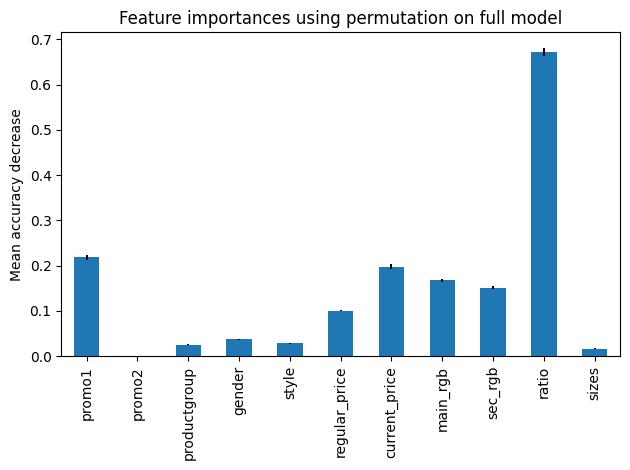

In [265]:
result = permutation_importance(
    pipe, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean,index=X_train.columns.values)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

0.010611840981552767 0.020547627847894767


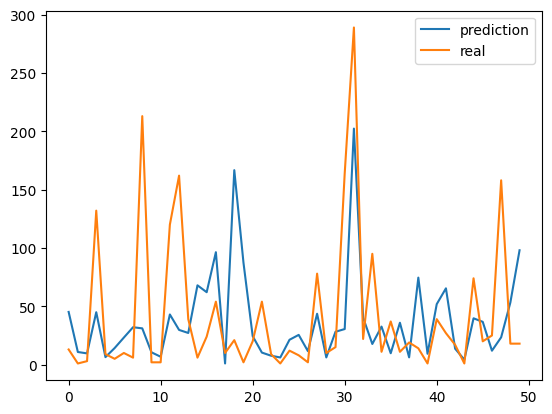

In [179]:
print(pipe.score(X_val,y_val),pipe.score(X_test,y_test))
plt.plot(pipe.predict(X_test.iloc[:50]),label="prediction")
plt.plot(y_test.iloc[:50].values,label="real")
plt.legend()

# make the plot

In [281]:
result_train = permutation_importance(
    pipe, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
result_test = permutation_importance(
    pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [285]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming result is the output from permutation_importance
forest_importances_train = pd.Series(result_train.importances_mean, index=X_train.columns.values)
importances_std_train = result_train.importances_std

forest_importances_test = pd.Series(result_test.importances_mean, index=X_train.columns.values)
importances_std_test = result_test.importances_std
# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Importance in Train", "Importance in Test"))

# Create a bar trace
bar_trace_train = go.Bar(x=forest_importances_train.index, y=forest_importances_train.values, error_y=dict(type='data', array=importances_std_train),name="Train Data")

bar_trace_test = go.Bar(x=forest_importances_test.index, y=forest_importances_test.values, error_y=dict(type='data', array=importances_std_test),name="Test Data")
# Add the same bar trace to both columns
fig.add_trace(bar_trace_train, row=1, col=1)
fig.add_trace(bar_trace_test, row=1, col=2)

# Customize the layout
fig.update_layout(title='Feature importances using permutation on the full model',
                  yaxis_title='Mean Importance')

# Show the plot
fig.show()
